# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [2]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [4]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [6]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [7]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [8]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        if scheduler is not None:
            scheduler.step(ave_loss)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        compare = torch.argmax(prediction, 1) == y_gpu
        correct_samples += compare.count_nonzero()
        total_samples += y_gpu.shape[0]
    
    return float(correct_samples) / total_samples

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.442298, Train accuracy: 0.516398, Val accuracy: 0.750870
Average loss: 0.730801, Train accuracy: 0.776866, Val accuracy: 0.776807
Average loss: 0.617341, Train accuracy: 0.814541, Val accuracy: 0.827657
Average loss: 0.559152, Train accuracy: 0.834880, Val accuracy: 0.820012
Average loss: 0.527474, Train accuracy: 0.842968, Val accuracy: 0.833185


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [9]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

E:\m\Prog\Anaconda\envs\dl\lib\site-packages\torchvision\transforms\transforms.py:1292: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  warnings.warn(


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

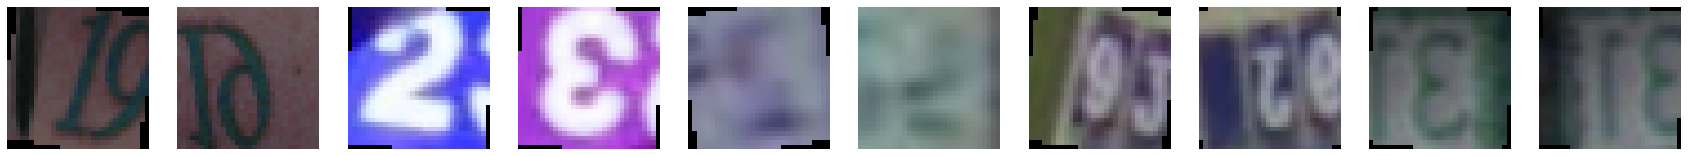

In [10]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

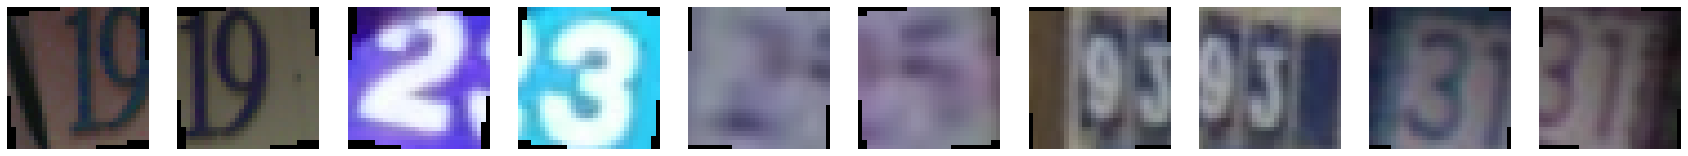

In [11]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    # transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.43,0.44,0.47],
    #     std=[0.20,0.20,0.20],
    # ),
])

# TODO create new instances of loaders with the augmentations you chose
train_aug_loader = None

data_aug_vis = dset.SVHN(
    './',
    transform=tfs
)

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.43,0.44,0.47],
        std=[0.20,0.20,0.20],
    ),
])

data_aug_train = dset.SVHN(
    './',
    transform=tfs
)

train_aug_loader = torch.utils.data.DataLoader(
    data_aug_train,
    batch_size=batch_size,
    sampler=train_sampler
)

In [12]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.610573, Train accuracy: 0.815309, Val accuracy: 0.829295
Average loss: 0.562746, Train accuracy: 0.828567, Val accuracy: 0.833049
Average loss: 0.541310, Train accuracy: 0.836536, Val accuracy: 0.847655
Average loss: 0.526828, Train accuracy: 0.840221, Val accuracy: 0.848270
Average loss: 0.513103, Train accuracy: 0.845425, Val accuracy: 0.837554


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [13]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
    nn.Conv2d(
        in_channels=3, out_channels=6,
        kernel_size=5, padding=0, stride=1
    ),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(inplace=True),

    nn.Conv2d(
        in_channels=6, out_channels=16,
        kernel_size=5, padding=0, stride=1
    ),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(inplace=True),

    nn.Conv2d(
        in_channels=16, out_channels=120, 
        kernel_size=5, padding=0, stride=1
    ),
    nn.ReLU(inplace=True),

    Flattener(),

    nn.Linear(in_features=120, out_features=84),
    nn.ReLU(inplace=True),

    nn.Linear(in_features=84, out_features=10),
)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [14]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.333188, Train accuracy: 0.548476, Val accuracy: 0.822811
Average loss: 0.557208, Train accuracy: 0.833567, Val accuracy: 0.862535
Average loss: 0.461854, Train accuracy: 0.864212, Val accuracy: 0.877005
Average loss: 0.412965, Train accuracy: 0.877060, Val accuracy: 0.889359
Average loss: 0.378245, Train accuracy: 0.886189, Val accuracy: 0.894546
Average loss: 0.354521, Train accuracy: 0.894806, Val accuracy: 0.894683
Average loss: 0.336927, Train accuracy: 0.898560, Val accuracy: 0.897823
Average loss: 0.320753, Train accuracy: 0.903884, Val accuracy: 0.898096
Average loss: 0.310437, Train accuracy: 0.906375, Val accuracy: 0.901235
Average loss: 0.293924, Train accuracy: 0.911477, Val accuracy: 0.893659


# Подбор гиперпараметров

In [15]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 5, 10, 15, 20, 50]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 5

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!

def search_hyperparams(learning_rate, reg):
    lenet_model = nn.Sequential(
        nn.Conv2d(
            in_channels=3, out_channels=6,
            kernel_size=5, padding=0, stride=1
        ),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(inplace=True),

        nn.Conv2d(
            in_channels=6, out_channels=16,
            kernel_size=5, padding=0, stride=1
        ),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(inplace=True),

        nn.Conv2d(
            in_channels=16, out_channels=120, 
            kernel_size=5, padding=0, stride=1
        ),
        nn.ReLU(inplace=True),

        Flattener(),

        nn.Linear(in_features=120, out_features=84),
        nn.ReLU(inplace=True),

        nn.Linear(in_features=84, out_features=10),
    )

    lenet_model.type(torch.cuda.FloatTensor)
    lenet_model.to(device)

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.SGD(lenet_model.parameters(), lr=learning_rate, weight_decay=reg)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience = 2, verbose = True)

    loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler)

    run_record[Hyperparams(learning_rate, reg)] = RunResult(lenet_model, train_history, val_history , val_history[-1])

for lr in learning_rates:
    for r in reg:
        print(f'learning_rate = {lr}\t;\treg = {r}')
        search_hyperparams(lr, r)

learning_rate = 1.0	;	reg = 0.001
Average loss: 2.243658, Train accuracy: 0.191738, Val accuracy: 0.188588
Average loss: 2.242068, Train accuracy: 0.188206, Val accuracy: 0.188588
Average loss: 2.242316, Train accuracy: 0.188223, Val accuracy: 0.188588
Average loss: 2.242463, Train accuracy: 0.187796, Val accuracy: 0.188588
Epoch 00005: reducing learning rate of group 0 to 5.0000e-01.
Average loss: 2.242194, Train accuracy: 0.188172, Val accuracy: 0.188588
learning_rate = 1.0	;	reg = 0.0001
Average loss: 2.245427, Train accuracy: 0.188189, Val accuracy: 0.188588
Average loss: 2.181132, Train accuracy: 0.224550, Val accuracy: 0.338543
Average loss: 2.098847, Train accuracy: 0.285363, Val accuracy: 0.222169
Average loss: 2.276922, Train accuracy: 0.189656, Val accuracy: 0.188588
Average loss: 2.242362, Train accuracy: 0.188564, Val accuracy: 0.188588
learning_rate = 1.0	;	reg = 1e-05
Average loss: 2.244271, Train accuracy: 0.188445, Val accuracy: 0.188588
Average loss: 2.242356, Train ac

In [16]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.90, best hyperparams: Hyperparams(learning_rate=0.1, reg=0.001)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [1]:
# RESTART

from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms


device = torch.device("cuda:0")

data_train = dset.SVHN(
    './',
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.43,0.44,0.47],
                std=[0.20,0.20,0.20]
            )
        ]
    )
)
data_test = dset.SVHN(
    './',
    split='test',
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.43,0.44,0.47],
                std=[0.20,0.20,0.20]
            )
        ]
    )
)

batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)


def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        if scheduler is not None:
            scheduler.step(ave_loss)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history


def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        compare = torch.argmax(prediction, 1) == y_gpu
        correct_samples += compare.count_nonzero()
        total_samples += y_gpu.shape[0]
    
    return float(correct_samples) / total_samples

In [8]:
# PARAMETERS

# DATA
use_batch_size = 64
# MODEL
use_kernel_size = 5
use_padding = 1
use_stride = 1
# OPTIMIZER
use_learning_rate = 1e-1
use_reg = 1e-4
# SCHEDULER
use_factor = 0.1
use_patience = 3
# TRAIN
use_epoch_num = 10

# MODEL

best_model = nn.Sequential(
    nn.Conv2d(
        in_channels=3, out_channels=6,
        kernel_size=use_kernel_size, padding=use_padding, stride=use_stride
    ),
    nn.BatchNorm2d(6),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(inplace=True),

    nn.Conv2d(
        in_channels=6, out_channels=16,
        kernel_size=use_kernel_size, padding=use_padding, stride=use_stride
    ),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(inplace=True),

    nn.Conv2d(
        in_channels=16, out_channels=120, 
        kernel_size=use_kernel_size, padding=use_padding, stride=use_stride
    ),
    nn.BatchNorm2d(120),
    nn.ReLU(inplace=True),

    Flattener(),

    nn.Linear(in_features=1920, out_features=120),
    nn.BatchNorm1d(120),
    nn.ReLU(inplace=True),

    nn.Linear(in_features=120, out_features=84),
    nn.BatchNorm1d(84),
    nn.ReLU(inplace=True),

    nn.Linear(in_features=84, out_features=10),
)
best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

# AUGMENTED

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.43,0.44,0.47],
        std=[0.20,0.20,0.20],
    ),
])

data_aug_train = dset.SVHN(
    './',
    transform=tfs
)

train_aug_loader = torch.utils.data.DataLoader(
    data_aug_train,
    batch_size=use_batch_size,
    sampler=train_sampler
)

# LOSS, OPTIMIZER, SCHEDULER

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
# optimizer = optim.SGD(best_model.parameters(), lr=use_learning_rate, weight_decay=use_reg)
optimizer = optim.Adagrad(best_model.parameters(), lr=use_learning_rate, weight_decay=use_reg)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=use_factor, patience=use_patience, verbose=True)

# TRAIN

loss_history, train_history, val_history = train_model(
    best_model,
    train_aug_loader,
    val_loader,
    loss,
    optimizer,
    use_epoch_num,
    scheduler
)

Average loss: 0.875461, Train accuracy: 0.709398, Val accuracy: 0.872159
Average loss: 0.416802, Train accuracy: 0.872641, Val accuracy: 0.898573
Average loss: 0.355105, Train accuracy: 0.890574, Val accuracy: 0.902805
Average loss: 0.317801, Train accuracy: 0.902416, Val accuracy: 0.902601
Average loss: 0.292702, Train accuracy: 0.910589, Val accuracy: 0.911542
Average loss: 0.270261, Train accuracy: 0.917210, Val accuracy: 0.915296
Average loss: 0.252187, Train accuracy: 0.922772, Val accuracy: 0.913043
Average loss: 0.232753, Train accuracy: 0.928625, Val accuracy: 0.913248
Average loss: 0.219917, Train accuracy: 0.932191, Val accuracy: 0.915842
Average loss: 0.209945, Train accuracy: 0.934955, Val accuracy: 0.918504


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [9]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.916641057160418
